# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [ ]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [ ]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [ ]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [ ]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [ ]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [4]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.230920, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278879, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.229127, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.159541, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.251741, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304623, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.025502, Train accuracy: 0.196778, val accuracy: 0.206000
Loss: 2.231987, Train accuracy: 0.201667, val accuracy: 0.205000
Loss: 2.168204, Train accuracy: 0.214444, val accuracy: 0.227000
Loss: 2.150686, Train accuracy: 0.232000, val accuracy: 0.239000
Loss: 1.964870, Train accuracy: 0.252556, val accuracy: 0.259000
Loss: 1.946651, Train accuracy: 0.269667, val accuracy: 0.271000
Loss: 1.959441, Train accuracy: 0.291667, val accuracy: 0.299000
Loss: 1.934680, Train accuracy: 0.310889, val accuracy: 0.326000
Loss: 1.764797, Train accuracy: 0.346778, val accuracy: 0.347000
Loss: 1.743196, Train acc

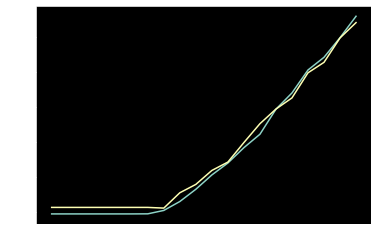

In [5]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [8]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.268760, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.197180, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.353785, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.200915, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.027092, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.127145, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.195379, Train accuracy: 0.197000, val accuracy: 0.206000
Loss: 1.985370, Train accuracy: 0.201000, val accuracy: 0.206000
Loss: 2.280994, Train accuracy: 0.212333, val accuracy: 0.223000
Loss: 2.271336, Train accuracy: 0.221222, val accuracy: 0.228000
Loss: 1.904730, Train accuracy: 0.237222, val accuracy: 0.244000
Loss: 1.973185, Train accuracy: 0.260222, val accuracy: 0.265000
Loss: 2.150753, Train accuracy: 0.279333, val accuracy: 0.288000
Loss: 2.085090, Train accuracy: 0.300000, val accuracy: 0.310000
Loss: 1.808974, Train accuracy: 0.328111, val accuracy: 0.332000
Loss: 1.681625, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [36]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.103130, Train accuracy: 0.197778, val accuracy: 0.206000
Loss: 1.547579, Train accuracy: 0.411222, val accuracy: 0.400000
Loss: 1.295204, Train accuracy: 0.536111, val accuracy: 0.552000
Loss: 0.978029, Train accuracy: 0.640556, val accuracy: 0.611000
Loss: 0.799238, Train accuracy: 0.665333, val accuracy: 0.648000
Loss: 1.063757, Train accuracy: 0.710333, val accuracy: 0.671000
Loss: 0.943930, Train accuracy: 0.723333, val accuracy: 0.697000
Loss: 0.855054, Train accuracy: 0.721333, val accuracy: 0.678000
Loss: 0.542999, Train accuracy: 0.744889, val accuracy: 0.687000
Loss: 0.781215, Train accuracy: 0.762778, val accuracy: 0.704000
Loss: 0.927544, Train accuracy: 0.788556, val accuracy: 0.716000
Loss: 0.735953, Train accuracy: 0.780444, val accuracy: 0.708000
Loss: 0.513450, Train accuracy: 0.801333, val accuracy: 0.713000
Loss: 0.449623, Train accuracy: 0.797222, val accuracy: 0.702000
Loss: 0.373643, Train accuracy: 0.841000, val accuracy: 0.736000
Loss: 0.711586, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [22]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.303085, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.295199, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.294738, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.310923, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.254763, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.262487, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.229849, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.126414, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.143855, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.314247, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.818495, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.820120, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.089383, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.870104, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.175332, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.338847, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [39]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=3e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.317286, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.316438, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.226646, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.250797, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.995526, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.971803, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 1.969251, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.586950, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.660163, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.911064, Train accuracy: 0.466667, val accuracy: 0.133333
Loss: 1.109971, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 0.997625, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.387186, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 1.362452, Train accuracy: 0.800000, val accuracy: 0.066667
Loss: 1.165219, Train accuracy: 0.866667, val accuracy: 0.066667
Loss: 0.340941, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [4]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-2
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None
best_learning_rate = None
best_learning_rate_decay = None
best_hidden_layer_size = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
best_val_accuracy = 0
for learning_rate in 10**np.linspace(-2,-2.5,3):
    for learning_rate_decay in [1, 0.999]:
        for hidden_layer_size in [100, 128]:
            print(f"*** Trainging with learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, hidden_layer_size={hidden_layer_size}")

            model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = reg_strength)
            dataset = Dataset(train_X, train_y, val_X, val_y)
            trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=learning_rate, learning_rate_decay=learning_rate_decay, num_epochs=num_epochs, batch_size=batch_size)

            loss_history, train_history, val_history = trainer.fit()
            if best_val_accuracy < val_history[-1]:
                best_val_accuracy = val_history[-1]
                best_classifier = model
                best_learning_rate = learning_rate
                best_learning_rate_decay = learning_rate_decay
                best_hidden_layer_size = hidden_layer_size

print('best validation accuracy achieved: %f' % best_val_accuracy)

2, val accuracy: 0.751000
Loss: 0.658187, Train accuracy: 0.858556, val accuracy: 0.750000
Loss: 0.465816, Train accuracy: 0.862000, val accuracy: 0.749000
Loss: 0.322529, Train accuracy: 0.854778, val accuracy: 0.745000
Loss: 0.375357, Train accuracy: 0.866111, val accuracy: 0.748000
Loss: 0.465149, Train accuracy: 0.863444, val accuracy: 0.745000
Loss: 0.312607, Train accuracy: 0.864889, val accuracy: 0.751000
Loss: 0.592114, Train accuracy: 0.872222, val accuracy: 0.750000
Loss: 0.497373, Train accuracy: 0.865778, val accuracy: 0.750000
Loss: 0.530872, Train accuracy: 0.872556, val accuracy: 0.750000
Loss: 0.536311, Train accuracy: 0.878778, val accuracy: 0.753000
Loss: 0.389098, Train accuracy: 0.878778, val accuracy: 0.750000
Loss: 0.784844, Train accuracy: 0.880444, val accuracy: 0.746000
Loss: 0.468745, Train accuracy: 0.877000, val accuracy: 0.745000
Loss: 0.528583, Train accuracy: 0.877333, val accuracy: 0.755000
Loss: 0.375031, Train accuracy: 0.881444, val accuracy: 0.746000

In [5]:
print(f"*** Best parameters: learning_rate={best_learning_rate}, learning_rate_decay={best_learning_rate_decay}, hidden_layer_size={best_hidden_layer_size}")

*** Best parameters: learning_rate=0.0031622776601683794, learning_rate_decay=1, hidden_layer_size=128


In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [6]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.747000
